In [1]:
import pandas as pd
import numpy as np
import psycopg2 as psql
import matplotlib.pyplot as plt
plt.style.use('seaborn-colorblind')
conn = psql.connect(dbname='datawarehouse',
                       host='localhost', user='gabriel', password='gyfu')

In [2]:
cur = conn.cursor()
cur.execute('select count(f.*), d.day, d.month, d.year from fires f left join date d on f.dateid = d.id group by d.day, d.month, d.year order by d.year, d.month, d.day asc;')

dailyData = cur.fetchall()
cur.close()
conn.close()

count = []
date = []

for fires in dailyData:
    count.append(fires[0])
    date.append(str(fires[1]) + '/' + str(fires[2]) + '/' + str(fires[3]))

firesDayDB = pd.DataFrame(data={'count': count, 'date': date})
firesDayDB = firesDayDB.set_index('date')

firesDayDB

,count
date,
1/1/2008,9
2/1/2008,22
3/1/2008,9
4/1/2008,20
5/1/2008,1
...,...
21/6/2017,64
22/6/2017,65
23/6/2017,56


In [3]:
from sklearn.preprocessing import StandardScaler
fires_norm = firesDayDB['count'].values.copy()
fires_norm.shape = (len(fires_norm), 1)

scaler = StandardScaler()
fires_norm = scaler.fit_transform(fires_norm)
firesDayDB['countNorm'] = fires_norm
firesDayDB.head(10)

,count,countNorm
date,,
1/1/2008,9,-0.567481
2/1/2008,22,-0.428347
3/1/2008,9,-0.567481
4/1/2008,20,-0.449752
5/1/2008,1,-0.653102
6/1/2008,26,-0.385537
7/1/2008,8,-0.578184
8/1/2008,11,-0.546076
9/1/2008,6,-0.599589


In [4]:
df = pd.DataFrame()
windowSize = 3
for i in range(0, windowSize + 1):
    df['E{}'.format(i)] = firesDayDB['countNorm'].shift(-i)
df = df.iloc[:-windowSize]
df

,E0,E1,E2,E3
date,,,,
1/1/2008,-0.567481,-0.428347,-0.567481,-0.449752
2/1/2008,-0.428347,-0.567481,-0.449752,-0.653102
3/1/2008,-0.567481,-0.449752,-0.653102,-0.385537
4/1/2008,-0.449752,-0.653102,-0.385537,-0.578184
5/1/2008,-0.653102,-0.385537,-0.578184,-0.546076
...,...,...,...,...
18/6/2017,-0.224997,-0.085863,0.363647,0.021163
19/6/2017,-0.085863,0.363647,0.021163,0.031865
20/6/2017,0.363647,0.021163,0.031865,-0.064458


In [5]:
arr = df.values
arr

array([[-0.56748101, -0.42834701, -0.56748101, -0.44975224],
       [-0.42834701, -0.56748101, -0.44975224, -0.65310194],
       [-0.56748101, -0.44975224, -0.65310194, -0.38553654],
       ...,
       [ 0.36364655,  0.02116285,  0.03186546, -0.06445808],
       [ 0.02116285,  0.03186546, -0.06445808, -0.11797115],
       [ 0.03186546, -0.06445808, -0.11797115, -0.32132085]])

In [6]:
x = arr[:, :-1]
target = arr[:, -1]
print(x)
print(target)

[[-0.56748101 -0.42834701 -0.56748101]
 [-0.42834701 -0.56748101 -0.44975224]
 [-0.56748101 -0.44975224 -0.65310194]
 ...
 [ 0.36364655  0.02116285  0.03186546]
 [ 0.02116285  0.03186546 -0.06445808]
 [ 0.03186546 -0.06445808 -0.11797115]]
[-0.44975224 -0.65310194 -0.38553654 ... -0.06445808 -0.11797115
 -0.32132085]


In [7]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_val_predict
from sklearn import metrics

mlp = MLPRegressor(hidden_layer_sizes=(200,400,), activation='logistic', max_iter=1000, solver='sgd')
fullPredict = cross_val_predict(mlp, x, target, cv=10)
print('Mean Squared Error: %s' %(metrics.mean_squared_error(target, fullPredict)))

Mean Squared Error: 0.5729623103520848


In [8]:
valuesAdd = list()
for i in range(0, windowSize):
    valuesAdd.append(float('NaN'))
fullPredict = np.insert(fullPredict, 0, valuesAdd)
fullPredict.shape = (len(fullPredict), 1)
fullPredict

array([[        nan],
       [        nan],
       [        nan],
       ...,
       [ 0.01862677],
       [-0.02909063],
       [-0.08077255]])

In [9]:
firesDayDB['predict'] = fullPredict
firesDayDB

,count,countNorm,predict
date,,,
1/1/2008,9,-0.567481,NaN
2/1/2008,22,-0.428347,NaN
3/1/2008,9,-0.567481,NaN
4/1/2008,20,-0.449752,-0.353868
5/1/2008,1,-0.653102,-0.316795
...,...,...,...
21/6/2017,64,0.021163,0.212721
22/6/2017,65,0.031865,0.090938
23/6/2017,56,-0.064458,0.018627


<AxesSubplot:xlabel='date'>

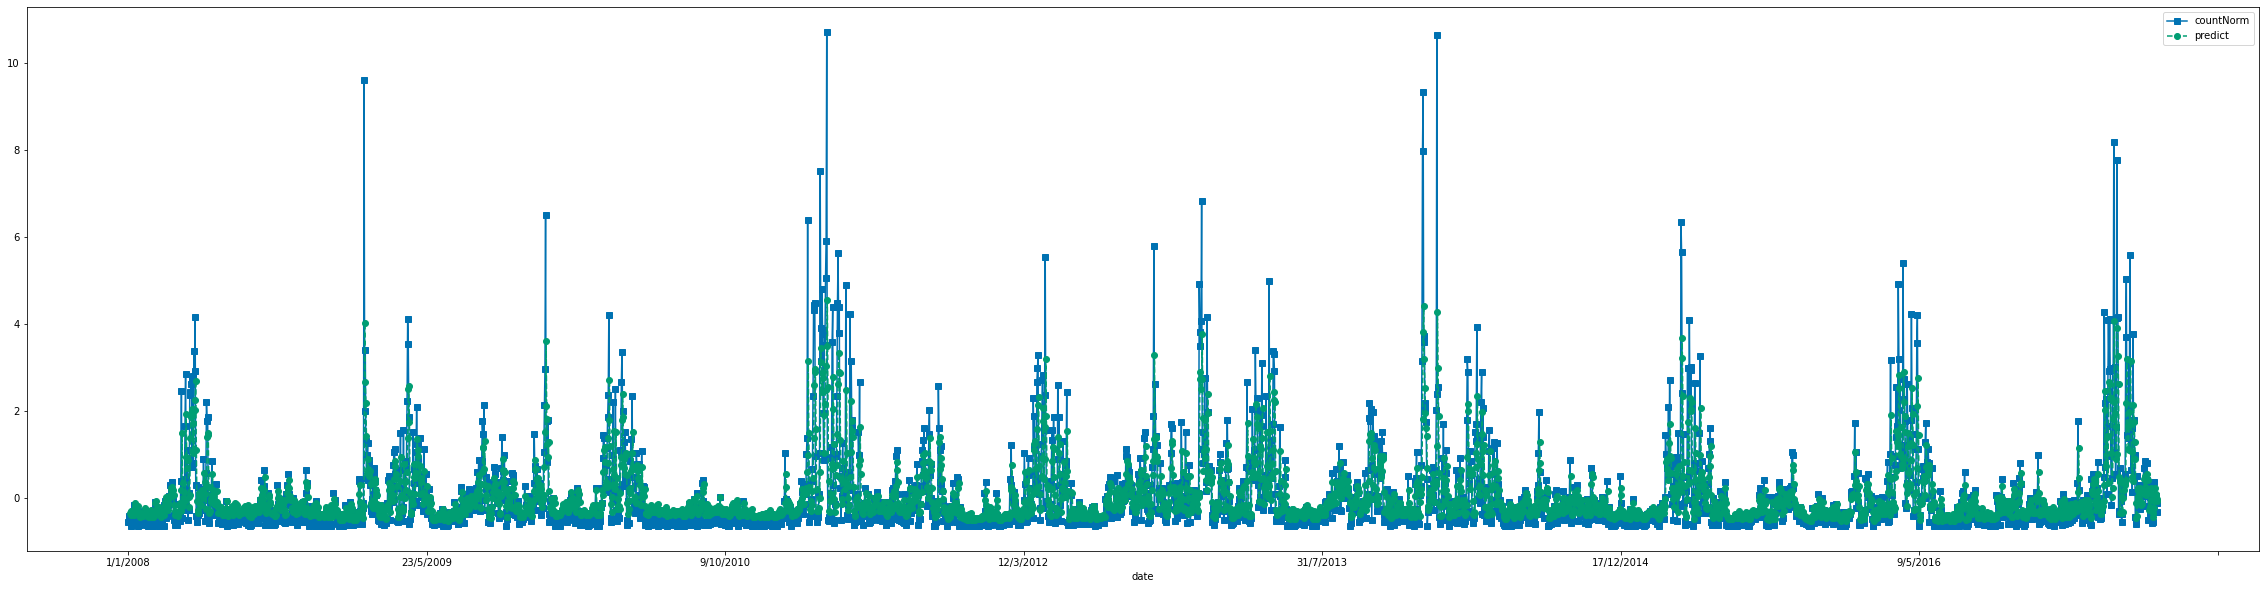

In [11]:
import matplotlib.pyplot as plt
firesDayDB.plot(y=['countNorm', 'predict'], style=['s-', 'o--'], figsize=(40,10))